In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import hj_reachability as hj

In [2]:
class AdaptiveCruiseControl(hj.dynamics.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 mass = 1.0,
                 v0 = 10.0,
                 control_mode="min",
                 disturbance_mode="max",
                 control_space=None,
                 disturbance_space=None):
        self.mass = mass
        self.v0 = v0
        self.min_acceleration = -self.mass * 9.81
        self.max_acceleration = -self.min_acceleration
        if control_space is None: 
            control_space = hj.sets.Box(jnp.array([self.min_acceleration]),
                                      jnp.array([self.max_acceleration]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(jnp.array([-0.5]), jnp.array([0.5]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)


    def F_r(self,v):
        f0 , f1 , f2 = 0.1, 0.01, 0.001
        return f0 + f1*v + f2*v**2
    
    def open_loop_dynamics(self, state, time , v0 = 10.0 , m = 1.0): #v0 is the constant velocity of the lead
        _, v, _ = state
        return jnp.array([v, (-1/m)*self.F_r(v), self.v0 - v])
    
    def control_jacobian(self, state, time, m = 1.0):
        _, v, _ = state
        return jnp.array(
            [[0.] , [(1/m)  ], [0]]
        )
    def disturbance_jacobian(self, state, time): 
        _, v, _ = state #disturbance is over the lead, how can it move?
        return jnp.array(
            [[0. ] , [0.], [1]] #the lead disturbance affects the distance
        )


In [3]:
dynamics = AdaptiveCruiseControl()
T_h = 0.5 #I want to be able to stop within 0.5 seconds

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([0, 0.0, 0.1]),
                                                                           hi=np.array([10.0, 15.0, 20.0])),
                                                               (50, 50, 50))

values = grid.states[..., 2] - T_h * grid.states[..., 1] 
solver_settings = hj.SolverSettings.with_accuracy("high")

print(grid.states.shape)
print(values.shape)

(50, 50, 50, 3)
(50, 50, 50)


In [4]:
time = 0.
target_time = -1.0 #Within the next 1 second, is anything unsafe?
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)

100%|##########|  1.0000/1.0 [00:01<00:00,  1.11s/sim_s]


In [5]:
fig = go.Figure(data=go.Isosurface(
    x=grid.states[..., 0].ravel(),
    y=grid.states[..., 1].ravel(),
    z=grid.states[..., 2].ravel(),
    value=target_values.ravel(),
    colorscale='jet',
    isomin=0,
    isomax=0,
    surface_count=1
))
fig.show()

25


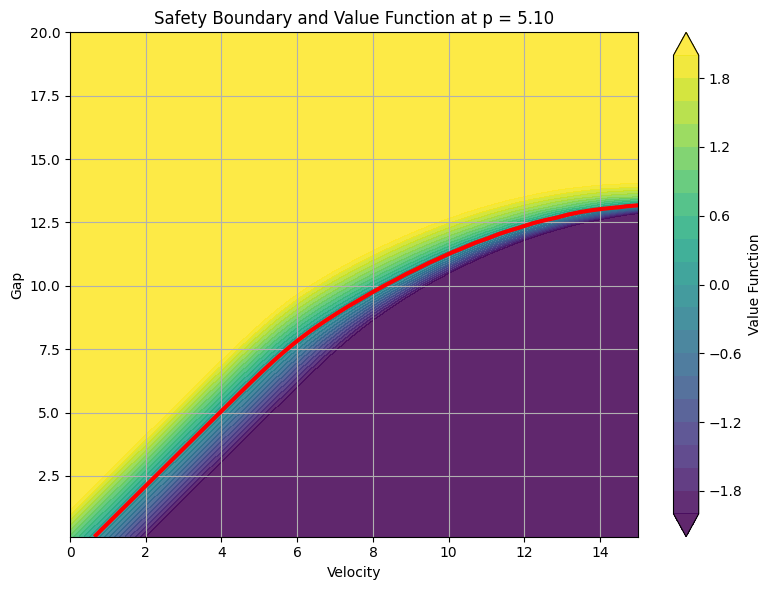

In [6]:
i = grid.states.shape[0] // 2
print(i)
X = grid.states[i, :, :, 1] #velocity
Y = grid.states[i, :, :, 2]
Z = target_values[i, :, :]

plt.figure(figsize=(8, 6))

# Choose a value range around zero for better contrast
vmin, vmax = -2, 2  # Adjust as needed for your data

# Use a perceptually uniform colormap
contourf = plt.contourf(X, Y, Z, levels=np.linspace(vmin, vmax, 21), cmap='viridis', alpha=0.85, extend='both')
plt.colorbar(contourf, label='Value Function')

# Overlay the zero level set (boundary) in red and thicker
contour = plt.contour(X, Y, Z, levels=[0], colors='red', linewidths=3)

plt.xlabel('Velocity')
plt.ylabel('Gap')
plt.title('Safety Boundary and Value Function at p = {:.2f}'.format(grid.states[i,0,0,0]))
plt.grid(True)
plt.tight_layout()
plt.show()  